# Vectorial Word Representations

## Background
Representing words as dense vectors over a finite-dimensional space was one of the recent breakthroughs in Natural Language Processing. Vectorial representations allow space-efficient, informationally rich storage of words that adequately captures their semantic content and enables numerical computation on them. Word vectors are the standard input representation for machine learning architectures for language processing. Even though new methods for constructing such representations emerge frequently, the original set of published papers remain a de facto point of reference as well as a good starting point. For this assignment, you will be asked to implement a small-scale variant of one such paper, namely [Global Word Vectors for Word Representation](https://nlp.stanford.edu/pubs/glove.pdf) ("the GloVe paper").

Notes on the paper will appear throughout the notebook to guide you along the code. It is, however, important to read and understand the paper, its terminology and the theory behind it before attempting to go through with the assignment. Some of the tasks will also require addressing the paper directly.

---

There are 2 types of tasks in this assignment:
- coding tasks --- asking you to write code following specifications provided; Most of the tasks come with test cases for sanity-check. Still, if something is not clear, <ins>do ask questions to lab teachers</ins>. When working with tensors, you have to use tensor-related operations instead of, e.g., inefficiently looping through tensor rows and columns.
- interpretation questions --- asking you to interpret the data or the results of the model

Each comes with its predefined points (totaling to 50pt). Some coding tasks have 0 points but solving them will be useful for you.

---

You are greatly encouraged to add comments to your code describing what particular lines of code do (in general, a great habit to have in your coding life).
Additionally please follow these rules when submitting the notebook:

* Put all code in the cell with the `# YOUR CODE HERE` comment.
* For theoretical questions, put your solution in the `YOUR ANSWER HERE` cell and keep the header(!).
* Don't change or delete any initially provided cells, either text or code, unless explicitly instructed to do so.
* Don't delete the comment lines `# TEST...` or edit their code cells. The test cells are for sanity checking. Passing them doesn't necessarily means that your code is fine.
* Don't change the names of provided functions and variables or arguments of the functions.
* Don't clear the output of your code cells.
* Don't output unnecessary info (e.g., printing variables for debugging purposes). This clutters the notebook and slows down the grading. You can have print() in the code, but comment them out before submitting the notebook.
* Delete those cells that you inserted for your own debuging/testing purposes.
* Don't forget to fill in the contribution information.
* Test your code and **make sure we can run your notebook** in the colab environment.
* A single notebook file (without archiving) per group should be submitted via BB.

<font color="red">You following these rules helps us to grade the submissions relatively efficiently. If these rules are violated, a submission will be subject to penalty points.</font>


# <font color="red">Contributions</font>

["Cem Kaya", "Murat Karaca"]
Equal contribution 

## Corpus Statistics

The paper's proposed model, GloVe, aims to densely represent words in a way that captures the global corpus statistics.

The construction it encodes is the word __co-occurrence matrix__. A co-occurrence matrix is a simplistic data structure that counts the number of times each word has appeared within the context of every other word. The definition of a context varies; usually, context is implied to be a fixed-length span (that may or may not be allowed to escape sentence boundaries) around a word.

For instance, in the sentence below and for a context length of 2, the word <span style="color:pink">__Earth__</span> occurs in the context of <span style="color:lightgreen">made</span> (1), <span style="color:lightgreen">on</span> (1), <span style="color:lightgreen">as</span> (1), <span style="color:lightgreen">an</span> (1).

> "He struck most of the friends he had <span style="color:lightgreen">made on</span> <span style="color:pink">__Earth__</span> <span style="color:lightgreen">as an</span> eccentric"

Similarly, the word <span style="color:pink">__friends__</span> occurs in the context of <span style="color:lightgreen">of</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">he</span> (1), <span style="color:lightgreen">had</span> (1).

> "He struck most <span style="color:lightgreen">of the</span> <span style="color:pink">__friends__</span> <span style="color:lightgreen">he had</span> made on Earth as an eccentric"

An alternative definition of a context would be, for instance, the variable-length windows spanned by a full sentence.

Contexts may be summed across sentences or entire corpora; the summed context of <span style="color:pink">__he__</span> in the example sentence is: <span style="color:lightgreen">struck</span> (1), <span style="color:lightgreen">most</span> (1), <span style="color:lightgreen">the</span> (1), <span style="color:lightgreen">friends</span> (1), <span style="color:lightgreen">had</span> (1), <span style="color:lightgreen">made</span> (1).



For the purposes of this assignment, we have prepared a co-occurrence matrix over a minimally processed version of the Harry Potter books.

(A few interpretation tasks in this assignment presuppose some minimal level of familiarity with the Harry Potter books/films. If no one in your group is familiar with Harry Potter, you might find the [fandom page](https://harrypotter.fandom.com/wiki/Main_Page) useful or the [synopsis sections](https://en.wikipedia.org/wiki/Harry_Potter_and_the_Philosopher%27s_Stone) of the corresponding wiki pages.

The pickle file contains three items:
1. `vocab`: a dictionary mapping words to unique ids, containing $N$ unique words
2. `contexts`: a dictionary mapping words to their contexts, where contexts are themselves dicts from words to integers that show the number of co-occurrences between these words.
    E.g. `{"portrait": {"harry": 124, "said": 114, ...}, ...}` meaning that the word "harry" has appeared in the context of the word "portrait" 124 times, etc.
3. `X`: a torch LongTensor ${X}$ of size $N \times N$, where ${X}[i,j]$ denotes the number of times the word with id $j$ has appeared in the context of the word with id $i$

Extremely common or uncommon words (i.e. words with too few or too many global occurrences) have been filtered out for practical reasons.

In [1]:
import pickle, math
import torch
#import numpy as np
from torch import FloatTensor, LongTensor
from typing import Dict, Callable, List
import matplotlib.pyplot as plt
# torch.set_printoptions(precision=8) #to increase precision of printing floats
#print gpu support
print("GPU available: ", torch.cuda.is_available())
torch.set_printoptions(precision=3, sci_mode=False)
MY_DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

GPU available:  True


In [2]:
# this command downloads the pickle file.
# This is not a python code, it is a unix code. You can run system commands in jupyter notebooks.
# !wget -nv -O HP-Counts.p https://www.dropbox.com/scl/fi/dnm7s38j8d0k0bguisiby/HP-Counts.p?rlkey=j0fc11rlnkow7jqb02sel6gz6&dl=1
# try this if download from the dropbox link doesn't work

#TODO delete comment before submition 
#!wget -nv -O HP-Counts.p https://naturallogic.pro/_files_/download/MLHVL/HP-Counts.p

In [3]:
with open("HP-Counts.p", "rb") as f:
    vocab, contexts, X = pickle.load(f)

Let's inspect the top 10 most frequent words in the context of the word 'portrait'.

In [4]:
sorted([(item, value) for item, value in contexts["portrait"].items()], key=lambda x: x[1], reverse=True)[:10]

[('harry', 124),
 ('said', 114),
 ('hole', 85),
 ('ron', 57),
 ('hermione', 54),
 ('room', 48),
 ('fat', 45),
 ('lady', 43),
 ('common', 37),
 ('back', 31)]

The co-occurrence matrix of a very large corpus should give a meaningful summary of how a word is used in general. A single row of that matrix is already a __word vector__ of size $N$. However such vectors are extremely sparse, and for large corpora the size of $N$ will become unwieldy. We will follow the paper in designing an algorithm that can compress the word vectors while retaining most of their informational content.

<div class="alert alert-block alert-info">
<b>Note:</b>
For the resulting vectors to actually be informative, the source corpus should have a size of at least a few billion words; on the contrary, our corpus enumerates merely a million words, so we can't expect our results to be as great.
</div>

### From co-occurrence to probabilities

Our matrix $X$ is very sparse; most of its elements are zero.

Find what the ratio of non-zero elements is.  
Check if the matrix is symmetric (think about why it should (not) be).

_Hint_: The function `non_zero_ratio` should return a `float` rather than a `FloatTensor`. Remember `.item()`.

In [5]:
# @title c1.1 [0pt]
def non_zero_ratio(sparse_matrix: LongTensor) -> float:
    num_zero= 0
    num_nan_zero = 0
    for i in range(sparse_matrix.shape[0]):
        for j in range(sparse_matrix.shape[1]):
            if sparse_matrix[i][j]== 0:
                num_zero += 1.0
            else:
                num_nan_zero += 1.0
                
    return num_nan_zero / (num_nan_zero + num_zero)
#non_zero_ratio(X)

In [6]:
# TEST c1.1
assert 0.1 < non_zero_ratio(X) < 0.2

We will soon need to perform division and find the logarithm of ${X}$. Neither of the two operations are well-defined for $0$. That's why for further processing we want to have a matrix without any zero elements.

Change the matrix's datatype to a `torch.float` and add a small constant to it such as $0.1$ to ensure numerical stability while maintaining sparsity. The obtained matrix will be used in the remaining sections (not the original one).

In [7]:
# @title c1.2 [0pt]
X1 =  X.float() +0.1 


In [8]:
# TEST c1.2
assert non_zero_ratio(X1) == 1

From the paper:
> Let the matrix of word-word co-occurrence counts be denoted by $X$, whose entries $X_{ij}$ tabulate the number of times word $j$ occurs in the context of word $i$.  Let $X_i$= $\sum_{k} X_{ik}$ be the number of times any word appears in the context of word $i$. Finally, let $P_{ij} = P(j  | i) =  X_{ij}/X_i$ be the probability that word $j$ appears in the context of word $i$.

Complete the function `to_probabilities` that accepts a co-occurrence matrix and returns the probability matrix $P$. Use tensor-specific functions and methods hiel doing this (e.g., don't loop through colums and rows of the tensor).

_Hint_: Remember broadcasting and `torch.sum()`.

In [9]:
# @title c1.3 [1pt]
def to_probabilities(count_matrix: FloatTensor) -> FloatTensor:
    Xi_vec = torch.sum(count_matrix, axis=1)
    #print("Xi_vec:  ",Xi_vec)
    return (count_matrix.T / Xi_vec).T 
# make a torch tensor to test the function
X = FloatTensor([[1.0001, 2.0001, 3.0001], 
                 [0.0001, 1.0001, 0.0001],
                 [0.0001, 0.0001, 1.0001]])
to_probabilities(X)

tensor([[    0.167,     0.333,     0.500],
        [    0.000,     1.000,     0.000],
        [    0.000,     0.000,     1.000]])

In [10]:
P = to_probabilities(X1) # note that we use X1 not X here

In [11]:
# TEST c1.3
assert P.shape == torch.Size([len(vocab), len(vocab)])

### Probing words

From the paper:
> Consider two words $i$ and $j$ that exhibit a particular aspect of interest. The relationship of these words can be examined by studying the ratio of their co-occurrence probabilities with various probe words, $k$.  For words $k$ related to $i$ but not $j$, we expect the ratio $P_{ik}/P_{jk}$ will be large.  Similarly, for words $k$ related to $j$ but not $i$, the ratio should be small. For words $k$ that are either related to both $i$ and $j$, or to neither, the ratio should be close to one.

Complete the function `query` that accepts two words $w_i$ and $w_j$, a vocab $V$ and a probability matrix ${P}$, maps each word to its corresponding index and returns the probability $P(j  |  i)$. If such probability is impossible to compute for input words, return float 0. probability.  

In [12]:
# @title c2.1 [1pt]
def query(word_i: str, word_j: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    if word_i in vocab.keys() and word_j in vocab.keys():
        w_i_idx = vocab[word_i]
        w_j_idx = vocab[word_j]
        
        prob_matrix = prob_matrix.double() 
        # P(j | i) = P(i, j) / P(i)
        P_i_j = prob_matrix[w_i_idx, w_j_idx]
        P_i = torch.sum(prob_matrix[w_i_idx])    
          
        result = P_i_j/P_i
        return float(result.float())
    else:
        return 0.0   
    
print(query('harry', 'potter', vocab, P) )
print(round(query('harry', 'potter', vocab, P), 5))

0.0035331191029399633
0.00353


In [13]:
# TEST c2.1

assert round(query('harry', 'potter', vocab, P), 5) == 0.00353

Then, complete the function `probe` that accepts three words $w_i$, $w_j$ and $w_k$, a vocab $V$ and a probability matrix ${P}$, calls `query` and returns the ratio $P(k |  i) / P(k  |  j)$. Let the function return 0 in case of division by 0.

In [14]:
# @title c2.2 [1pt]
def probe(word_i: str, word_j: str, word_k: str, vocab: Dict[str, int], prob_matrix: FloatTensor) -> float:
    if word_i in vocab.keys() and word_j in vocab.keys() and word_k in vocab.keys():
        w_i_idx = vocab[word_i]
        w_j_idx = vocab[word_j]
        w_k_idx = vocab[word_k]
        
        prob_matrix = prob_matrix.double() 
        
        P_k_i = prob_matrix[w_i_idx, w_k_idx]
        P_k_j = prob_matrix[w_j_idx, w_k_idx]
        P_i = torch.sum(prob_matrix[w_i_idx])    
        P_j = torch.sum(prob_matrix[w_j_idx])
        
        result_k_i = P_k_i/P_i
        result_k_j = P_k_j/P_j
        if result_k_i == 0 or result_k_j == 0:
            return 0.0         
        else:
            return float(result_k_i / result_k_j) 
    else:
        return 0.0   
print(round(probe('harry', 'potter', 'stone', vocab, P), 4)) 

1.3872


In [15]:
# TEST c2.2
assert round(probe('harry', 'potter', 'stone', vocab, P), 4) == 1.3872

Let's probe a few words and examine whether the authors' claim holds even for our (tiny) corpus. **Add two pairs of your own word triplets** and experiment on them.

In [16]:
print("tea", "wand", "magic", probe("tea", "wand", "magic", vocab, P))
print("tea", "wand", "cup", probe("tea", "wand", "cup", vocab, P))
print()
# YOUR CODE HERE
print("broom", "fly", "race", probe("broom", "fly", "race", vocab, P))

print("horse", "store",  "magic", probe("horse", "store",  "magic", vocab, P))

print("train", "school", "magic", probe("train", "school", "magic", vocab, P))


tea wand magic 0.01844294403415497
tea wand cup 26.142657031012345

broom fly race 0.5891650549330356
horse store magic 0.6862182070504376
train school magic 0.09433587186475488


#### i1 [1pt]
Give a brief interpretation of the results you got. Do they correspond to your expectations? Why or why not?

*Hint*: When do we expect the ratio value to be high, low or close to 1? Refer to the GloVe paper for guidance.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>




Yes, the results we got corespond to our expectations. 

For the words tea wand magic example we were expecting a score of less then 1. Which we got. Since the word pairs  (tea, magic) are not strongly correlated in our daily lexicon and the word pairs (magic, wand) are strongly correlated the ratio should have been less then 1 which it was. This further suggests the word distribution of harry potter is somewhat similar to our daily use word distribution. 

The second example tea wand cup results were also in an expected ratio. We were expecting a high value due to the words pair (tea,cup) are very strongly corolated in our daily lexicon, while tea wand are not common. 

By relying on the previous test we have run an experiment to see the correlation between the broom fly race words. (broom, race) / (fly, race). As per our knowledge of HP universe there is a race game with flying brooms. However, we were not sure of the authors phrasing of this sport so we have run this test as an experiment. We were expecting a result close to 1 where we got 0.5 which suggests (fly, race) is more common. 

The words horse store magicwere also used as an experiment to test if magic horses were more common then the magic stores and this resulted in  a result of 0.68 which suggests magic stores were more common in the HP books by not a significant ratio. 

The words train school magic were also used as an experiment. Which resulted in a score of 0.09 which suggests that the word pair (school, magic ) is significantly more common then the word pair (train, magic). 


What would happen if we tried probing out-of-domain words? Use the words "solid", "gas", "water", and "fashion", which the authors report in the paper in the context of "ice" and "steam" (Table 1). Make your code to clearly print the details.

In [17]:
print("ice", "steam", "solid", probe("ice", "steam", "solid", vocab, P))
print("ice", "steam", "gas", probe("ice", "steam", "gas", vocab, P))
print("ice", "steam", "water", probe("ice", "steam", "water", vocab, P))
print("ice", "steam", "fashion", probe("ice", "steam", "fashion", vocab, P))

ice steam solid 0.07830312919204734
ice steam gas 0.8613344137869313
ice steam water 1.2714936818107796
ice steam fashion 0.8613344137869313


#### i2 [3pt]
Give an interpretation of the results you got. Do they match what the authors report in the paper? Why or why not?

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>


|     | Our result | Paper result   |
|-----------|-----------|-----------|
| ice steam solid | 0.078 | 8.9 |
| ice steam gas| 0.861 |  0.085 |
| ice steam water | 1.271 | 1.36 |
| ice steam fashion | 0.861 | 0.96 |


Some results are with in the expected range of deviation  from the results from the paper given the word count and domain differences of our word corpus. (i.e. ice steam fashion  and  ice steam water) are very close to the authors results. For these words  our results were 10% off the results form the paper. However, the results for ( ice steam gas)and especially  (ice steam solid ) were significantly off from the results from the paper. The ( ice steam gas) was off by  an order of magnitude  and the ( ice steam solid) was off by two orders of magnitude.  We suspect that this difference stems from the differences in our word corpus. There might be a spell or a place which contains the words which were used for the comparison. This would require more intimate knowledge of harry potter and some data mining to be investigated further.  

## Dense Vectors

Now, we would like to convert these long sparse vectors into short dense ones.

The conversion should be such that the probability ratios we inspected earlier may still be reconstructed via some (for now, unknown) operation $F$ on the dense vectors.

To restrict the search space over potential functions, the authors impose a number of constraints they think $F$ should satisfy:
1. > While $F$ could be taken to be a complicated function parameterized by, e.g., a neural network, doing so would obfuscate the linear structure we are trying to capture. $F$ should be dot-product based.
2. > The distinction between a word and a context word is arbitrary and we are free to exchange the two roles. To do so consistently, we must not only exchange $w \leftrightarrow \tilde{w}$ but also $X \leftrightarrow X^T$.
3. > It should be well-defined for all values in $X$.

Given these three constraints, each word $i$ in our vocabulary is represented by four vectors:
1. A vector $w_i \in \mathbb{R}^D$
2. A bias $b_i \in \mathbb{R}$
3. A context vector $\tilde{w}_i \in \mathbb{R}^D$
4. A context bias $\tilde{b}_i \in \mathbb{R}$

and $F: \mathbb{R}^D \times \mathbb{R} \times \mathbb{R}^D \times \mathbb{R} \to \mathbb{R}$ is defined as:

$F(w_i, \tilde{w}_k, b_i, \tilde{b}_k) = w_i^T\tilde{w}_k + b_i + \tilde{b}_k$.

Or equivalently the least squares error $J$ is minimized, where:

$J = \sum_{i,j=1}^{V} f(X_{ij})(w_{i}^T\tilde{w}_j + b_i + \tilde{b}_j - log(X_{ij}))^2$

with $f$ being a weighting function, defined as

$$
f(x) = \begin{cases}
    \left(\frac{x}{x_{\text{max}}}\right)^\alpha, & \text{if } x < x_{\text{max}} \\
    1, & \text{otherwise}.
  \end{cases}
$$

### Weighting Function

Let's start with the last part.

Complete the weighting function `weight_fn` which accepts a co-occurrence matrix ${X}$, a maximum value $x_{max}$ and a fractional power $\alpha$, and returns the weighted co-occurrence matrix $f({X})$.

Then, compute $\text{X\_weighted}$, the matrix $X$ after weighting, using the paper's suggested parameters.


_Hint_: Note that $f$ is defined pointwise, so our weighting function should also be pointwise. Use tensor-specific functions/methods.

In [18]:
# @title c3 [1pt]
def weight_fn(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
    weight = torch.where(X < x_max, ((X / x_max) ** alpha), 1)
    return weight


def weight_fn_2(X: FloatTensor, x_max: int, alpha: float) -> FloatTensor:
    weight = torch.ones_like(X) 
    
    mask = X < x_max  
    weight[mask] = (X[mask] / x_max) ** alpha  
        
    return weight


In [19]:
X_weighted = weight_fn(X1, x_max=100, alpha=3/4)

In [20]:
# TEST c3
assert X_weighted.shape == X1.shape

Try to get an understanding of how the weighting affects different co-occurrence values (high and low). Think of some word pairs with high and low co-occurrence and look them up in $X$ and in $\text{X\_weighted}$ to get a better idea.

In [21]:
# YOUR CODE HERE

X_high = round(query('expecto', 'patronum', vocab, X1), 5)  # Harry Potter magic
X_low = round(query('horse', 'store', vocab, X1), 5)

X_high_weight = round(query('expecto', 'patronum', vocab, X_weighted), 5)
X_low_weight = round(query('horse', 'store', vocab, X_weighted), 5)

print(f"expecto patronum           {X_high:.5f}")
print(f"weighted: expecto patronum {X_high_weight:.5f}")

print(f"horse store           {X_low:.5f}")
print(f"weighted: horse store {X_low_weight:.5f}")


expecto patronum           0.05129
weighted: expecto patronum 0.01829
horse store           0.00007
weighted: horse store 0.00012


### Loss Function

The next step is to write the loss function.

We can write it as a pointwise function, apply it iteratively over each pair of words and then sum the result; that's however extremely inefficient.

Inspecting the formulation of $J$, it is fairly straightforward to see that it can be immediately implemented using matrix-matrix operations, as:

$J = \sum_{i,j=1}^{V}f(\mathbf{X})\cdot(W\tilde{W}^T + b + \tilde{b}^T - log(X))^2$,

where $W$, $\tilde{W}$ are the $N \times D$ matrices containing the $D$-dimensional vectors of all our $N$ vocabulary words, and $b$, $\tilde{b}$ are the $N \times 1$ matrices containing the $1$-dimensional biases of our words.

Complete `loss_fn`, a function that accepts a weighted co-occurrence matrix $f({X})$, the word vectors and biases $W$, $\tilde{W}$, $b$, $\tilde{b}$ and the co-occurrence matrix ${X}$, and computes $J$.

In [22]:
# @title c4 [1pt]
def loss_fn(
    X_weighted: FloatTensor,
    W: FloatTensor,
    W_context: FloatTensor,
    B: FloatTensor,
    B_context: FloatTensor,
    X: FloatTensor
) -> FloatTensor: # we need a tensor type as an output to be able to do backward propagation with it
    
    
    loss = torch.sum( X_weighted * ((W @ W_context.T + B + B_context.T - torch.log(X))**2 ) ) 
    
    return loss

Let's make sure that we are on a right track. For this we calculate the loss function with toy input: matrices are of size $2 \times 2$ while bias vectors of size $2 \times 1$. You can verify the answer manually and with your implementation of `loss_fn`.

In [23]:
# TEST c4
toy_X_weighted = torch.FloatTensor([[.5,1],[.2,.1]])
toy_X1 = torch.FloatTensor([[2,1],[1,5]])
toy_W1 = torch.FloatTensor([[1,2],[1,0]]) # for W
toy_W2 = torch.FloatTensor([[0,1],[1,2]]) # for W~
toy_b1 = torch.FloatTensor([[0],[2]]) # for b
toy_b2 = torch.FloatTensor([[2],[1]]) # for b~
# fill the correct value
assert loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1).isclose((torch.tensor([45.239116])))
#print(loss_fn(toy_X_weighted, toy_W1, toy_W2, toy_b1, toy_b2, toy_X1)) #Checked by TA

### GloVe

We have the normalized co-occurrence matrix ${X}$, the weighting function $f$, and the loss function $J$ that implements $F$.

What we need now is a mapping from words (or word ids) to unique, parametric and trainable vectors.

Torch provides this abstraction in the form of [Embedding layers](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding). Each such layer may be viewed as a stand-alone network that can be optimized using the standard procedure we have already seen. It is recommended to read about Embedding class. In general, it does the same job as `nn.Parameter(torch.rand(...))` but additionally allows to select row vectors by giving a list of token indices.   

We will utilize the `nn.Module` class to contain all our embedding layers and streamline their joint optimization.
The container class will be responsible for a few things:

1. Wrapping the embedding layers:
    1. A vector embedding that maps words to $w \in \mathbb{R}^D$
    2. A context vector embedding that maps words to $w_c \in \mathbb{R}^D$
    3. A bias embedding that maps words to $b \in \mathbb{R}^1$
    4. A context bias embedding that maps words to $b_c \in \mathbb{R}^1$
2. Implementing `forward`, a function that accepts a weighted co-occurrence matrix $f(X)$, the co-occurrence matrix $X$, then finds the embeddings of all words and finally calls `loss_fn` as defined above.
3. Implementing `get_vectors`, a function that receives no input and produces the word vectors and context word vectors of all words, adds them together and returns the result, in accordance with the paper:
> ...With this in mind, we choose to use the sum $W + \tilde{W}$ as our word vectors.

Complete the network class following the above specifications.  

In [24]:
# @title c5 [4pt]
class GloVe(torch.nn.Module):
    def __init__(self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu", seed: int=0) -> None:
        super(GloVe, self).__init__()
        self.device = device
        self.vocab_len = len(vocab)
        torch.manual_seed(seed) #random initialization of w, wc, b, bc is fixed by the seed
        self.w = torch.nn.Embedding(self.vocab_len, vector_dim, device = self.device)
        self.wc = torch.nn.Embedding(self.vocab_len, vector_dim, device = self.device)
        self.b = torch.nn.Embedding(self.vocab_len, 1, device = self.device)
        self.bc = torch.nn.Embedding(self.vocab_len, 1, device = self.device)

    def forward(self, X_weighted: FloatTensor, X: FloatTensor) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input).to(self.device)
        W_context = self.wc(embedding_input).to(self.device)
        B = self.b(embedding_input).to(self.device)
        B_context = self.bc(embedding_input).to(self.device)

        X_weighted = X_weighted.to(self.device)
        X = X.to(self.device)

        loss = loss_fn(X_weighted, W, W_context, B, B_context, X)
        return loss

    def get_vectors(self) -> FloatTensor:
        embedding_input = torch.arange(self.vocab_len).to(self.device)
        W = self.w(embedding_input)
        W_context = self.wc(embedding_input)
        
        return W + W_context

In [25]:
# TEST c5
assert GloVe(vocab, vector_dim=30, seed=0).w.num_embeddings == len(vocab)
assert GloVe(vocab, vector_dim=30, seed=0).bc.num_embeddings == len(vocab)

### Training

Everything is in place; now we may begin optimizing our embedding layers (and in doing so, the vectors they assign).

Instantiate the network class you just defined using $D = 30$. Then instantiate an `Adam` optimizer with a learning rate of 0.05 and train your network for 300 epochs (don't change the default seed value).

When writing the training script, remember that your network's forward pass is __already__ computing the loss. Make sure to **print a loss value for each epoch**.

Training won't take too long on a CPU. In case you want to use a GPU, make sure that variables are correctly moved to a GPU with a `device` argument of class `GloVe`.

In [26]:
# @title c6.1 [4pt]
def train_glove_vectors(voc: Dict[str, int], X_weighted: FloatTensor, X1:FloatTensor,
                        vector_dim: int=30, seed: int=0, lr: float=0.05, num_epochs: int=300):
    
    network = GloVe(voc, vector_dim, seed=seed, device=MY_DEVICE) #self, vocab: Dict[str, int], vector_dim: int=30, device: str="cpu", seed: int=0
    opt = torch.optim.Adam(network.parameters(), lr=lr)

    
    losses = [] # collect losses for each epoch here
    for i in range(num_epochs):
        loss = network.forward(X_weighted, X1)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        #for matplotlib to cpu 
        losses.append(loss.detach().cpu().numpy())
        
        print(f"Epoch {i:>3}: training Loss: {loss}")
        
    return losses, network



In [27]:
# TEST
losses, network = train_glove_vectors(vocab, X_weighted, X1)


Epoch   0: training Loss: 11367346.0
Epoch   1: training Loss: 9867104.0
Epoch   2: training Loss: 8570608.0
Epoch   3: training Loss: 7455399.0
Epoch   4: training Loss: 6498993.5
Epoch   5: training Loss: 5680457.0
Epoch   6: training Loss: 4980712.0
Epoch   7: training Loss: 4382609.0
Epoch   8: training Loss: 3870921.5
Epoch   9: training Loss: 3432295.25
Epoch  10: training Loss: 3055150.25
Epoch  11: training Loss: 2729535.5
Epoch  12: training Loss: 2446973.0
Epoch  13: training Loss: 2200302.75
Epoch  14: training Loss: 1983546.625
Epoch  15: training Loss: 1791783.25
Epoch  16: training Loss: 1621044.0
Epoch  17: training Loss: 1468217.75
Epoch  18: training Loss: 1330956.75
Epoch  19: training Loss: 1207572.25
Epoch  20: training Loss: 1096907.25
Epoch  21: training Loss: 998182.875
Epoch  22: training Loss: 910820.1875
Epoch  23: training Loss: 834264.125
Epoch  24: training Loss: 767845.25
Epoch  25: training Loss: 710710.9375
Epoch  26: training Loss: 661839.0
Epoch  27: t

<font color="red">**Don't clear the output of the above cell!**</font>

In [28]:
# TEST c6.1
assert len(losses) == 300
assert losses[0] > losses[-1]

Plot the losses (x axis for epoch number and y axis for loss) and examine the learning curve. Ask yourself, is its shape what you would expect it to be?

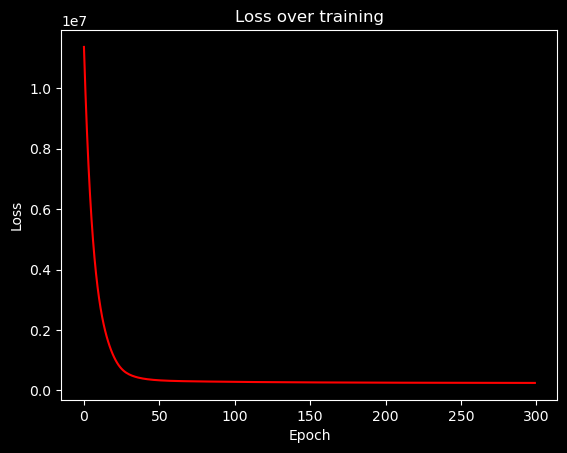

In [29]:
# @title c6.2 [0pt]

plt.plot(losses,color='red')
plt.title("Loss over training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()


<font color="red">**Don't clear the output of the above cell!**</font>

### Validation (Similarity)

Curious to see what this network has learned? Let's perform a simple validation experiment.

We will check which words the model considers the most similar to other words. To that end, we need a notion of __similarity__. One of the most common measures of similarity in high-dimensional vector spaces is the cosine similarity.

The cosine similarity of two vectors $\vec{a}, \vec{b}$ is given as:
$$sim(\vec{a}, \vec{b}) = \frac{\vec{a}\cdot \vec{b}}{|\vec{a}|_2 \cdot |\vec{b}|_2}$$

where $|\vec{x}|_2$ is the $L_2$-norm of the $\vec{x}$.

The function `similarity` below accepts two words, a vocabulary and the network's output vectors, and computes the similarity between these two words. For an outside-vocabulary word similarity is 0.

In [30]:
def similarity(word_i: str, word_j: str, vocab: Dict[str, int], vectors: FloatTensor) -> float:
    if not(word_i in vocab and word_i in vocab): return 0.
    i, j = vocab[word_i], vocab[word_j]
    v_i = vectors[i] / torch.linalg.vector_norm(vectors[i])  # a/|a|
    v_j = vectors[j] / torch.linalg.vector_norm(vectors[j])  # b/|b|
    sim = torch.dot(v_i, v_j)
    return sim

Let's check out some examples. Consider the word pairs below and, optionally, add your own word pairs if it helps to support your answer:

In [31]:
word_vectors = network.get_vectors().detach()

for pair in [
    ("cruciatus", "imperius"),
    ("avada", "kedavra"),
    ("hogwarts", "school"),
    ("goblin", "hagrid"),
    ("giant", "hagrid"),
    ("red", "ice"),
    ("ice", "ice"),
    ("ice", "snow"),
    ("blade", "sword"),
    ("wand", "magic"),
    ("expecto", "patronum"),
    ("bird", "owl"),     
]:
    print(f"Similarity between '{pair[0]}' and '{pair[1]}' is: {similarity(pair[0], pair[1], vocab, word_vectors)}")

Similarity between 'cruciatus' and 'imperius' is: 0.5572267770767212
Similarity between 'avada' and 'kedavra' is: 0.7137672901153564
Similarity between 'hogwarts' and 'school' is: 0.6364777088165283
Similarity between 'goblin' and 'hagrid' is: 0.10509191453456879
Similarity between 'giant' and 'hagrid' is: 0.6429957151412964
Similarity between 'red' and 'ice' is: 0.227581188082695
Similarity between 'ice' and 'ice' is: 1.0
Similarity between 'ice' and 'snow' is: 0.3064606189727783
Similarity between 'blade' and 'sword' is: 0.0
Similarity between 'wand' and 'magic' is: 0.17227309942245483
Similarity between 'expecto' and 'patronum' is: 0.7809162139892578
Similarity between 'bird' and 'owl' is: 0.1517755091190338


#### i3 [2pt]
Give an interpretation of the results. Do the scores correspond well to your perceived similarity of these word pairs?

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

Yes, the results for word similarity calculations mostly make sense per our preconceived word similarities. However, given the unique word corpus of HP books there are some unexpected results.

Our group watched the film series of Harry Potter years ago, but we did not read the books at all. The high cosine similarites of spell name parts make sense, since spell name parts are related to each other such as 'avada kedavra' or 'expecto patronum'. Also, Hagrid in film series looks like a giant, so 'giant' and 'hagrid' word pairs has high similarity. On the other hand, when we tried other word pairs like 'bird' and 'owl', the similarity rate of 'bird' and 'owl' were lower than we expected. This could have been due to harry potter's word corpus, it resulted in low similarity scores that should normally been higher than 0.15 per our preconceived word understaning. Especially 'blade' and 'sword' word pair, we got 0 cosine similarity, but this word pair should have a similarity which shows word corpus of harry potter is not enough to perceive some word pairs similarities. This one makes more sense since HP does not contain any significant sword play which resulted in these words beeing out of distribution.   

To obtain the similarities of one word against all other words in the corpus, use torch functions and follow the equation ($\vec{c}_i$ is $i$th row of $\mathbf{C}$):
$$sim(\vec{w}, \mathbf{C}) = \frac{\vec{w}\cdot \mathbf{C}}{|\vec{w}|_2 \cdot |\mathbf{C}|_2} = \Big(\frac{\vec{w}\cdot \vec{c}_1}{|\vec{w}|_2 \cdot |\vec{c}_1|_2},\ldots,\frac{\vec{w}\cdot \vec{c}_N}{|\vec{w}|_2 \cdot |\vec{c}_N|_2}\Big)$$

Using `similarity` as a reference, write `similarities`, which accepts one word, a vocabulary and the network's output vectors and computes the similarity between the word and the entire corpus. **If a word is out of vocabulary, it should return a matrix of 0 similarities.**

_Hint_: $\mathbf{C} \in \mathbb{R}^{N, D}$, $\vec{w} \in \mathbb{R}^{1, D}$, $sim(\vec{w}, \mathbf{C}) \in \mathbb{R}^{1, N}$

In [32]:
# @title c7 [4pt]
def similarities(word_i: str, vocab: Dict[str, int], vectors: FloatTensor) -> FloatTensor:
    # use torch functions. Don't iterate over rows of vectors matrix!
    if not(word_i in vocab): return torch.zeros(len(vocab)).unsqueeze(0)
    i = vocab[word_i]
    v_i = vectors[i] / torch.linalg.vector_norm(vectors[i])  # a/|a|
    sims = torch.mv(vectors, v_i)  # dot product of each row with v_i
    return sims.unsqueeze(0).to("cpu")

In [33]:
torch.tensor([1, 2, 3, 4]).unsqueeze(0)

tensor([[1, 2, 3, 4]])

In [34]:
# TEST c7a
assert similarities('harry', vocab, word_vectors).shape == torch.Size([1, len(vocab)])
assert similarities('cow', vocab, word_vectors).shape == torch.Size([1, len(vocab)])

Now we can manipulate the word vectors to find out what the corpus-wide most similar words to a query word are!

In [35]:
def most_similar(word_i: str, vocab: Dict[str, int], vectors: FloatTensor, k: int) -> List[str]:
    """ Returns a list of k words that are most similar to word_i
        The list excludes word_i itself
    """
    sims = similarities(word_i, vocab, vectors)
    _, topi = sims.topk(dim=-1, k=k+1)
    topi = topi.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in topi if inv[i] != word_i][:k]

In [36]:
# TEST c7b
for word in [
    "forbidden", "myrtle", "gryffindor", "wand", "quidditch", "marauder",
    "horcrux", "phoenix", "triwizard", "screaming", "letter"
]:
    print(f"Most similar words to '{word}': {most_similar(word, vocab, word_vectors, 6)}")

Most similar words to 'forbidden': ['ahead', 'hagrid', 'windows', 'forest', 'centaurs', 'icy']
Most similar words to 'myrtle': ['bathroom', 'toilet', 'moaning', 'kreacher', 'pomfrey', 'wing']
Most similar words to 'gryffindor': ['team', 'clock', 'slytherin', 'common', 'points', 'match']
Most similar words to 'wand': ['harry', 'back', 'ollivander', 'elder', 'know', 'expelliarmus']
Most similar words to 'quidditch': ['team', 'match', 'wood', 'training', 'oliver', 'angelina']
Most similar words to 'marauder': ['map', 'goyle', 'lift', 'filch', 'pocket', 'office']
Most similar words to 'horcrux': ['griphook', 'sword', 'hallows', 'horcruxes', 'deathly', 'wormtail']
Most similar words to 'phoenix': ['fawkes', 'wormtail', 'archway', 'innocent', 'clunk', 'grindelwald']
Most similar words to 'triwizard': ['tournament', 'winky', 'bagman', 'maze', 'amos', 'durmstrang']
Most similar words to 'screaming': ['pettigrew', 'kreacher', 'giggling', 'lynch', 'darkness', 'run']
Most similar words to 'letter

#### i4 [3pt]

Interpret the results in the context of Harry Potter books.
- Do these most similar words make sense (are they actually similar to the query words)?
- Are there any patterns you can see in the "errors" (the words that you wouldn't consider actually similar to the query word in general, in everyday life)?
- Which examples are instances of similarity (if any) and relatedness (if any)?
- Any other observations are welcome.

Illustrate your answers with examples from your model's output.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

Yes, these similarities mostly make sense. Especially, the words letter and its results  ['envelope', 'cage', 'paper', 'owl', 'hedwig', 'writing'] is a great example of this method resulting in in encapsulation of similarities in the vector space. This word results in a lot of related words as well however the word with highest score is literally a synonym of the input word.  However, other words such as quidditch result in related words instead of similar words. This could be due to quidditch not having a similar word in the HP books. If our corpus contained more words form the real life we would expect a sport like tennis resulting in a high similarity like a sport like badminton or table tennis. This does mean the world of HP  does not have another sport like quidditch.

The word horcrux resulted in horcruxes which is literally the plural form of the input word. However, it not being the word with the highest similarity was unexpected. Furthermore, the word with the highest similarity being griphook who is a goblin working in a bank was more baffling as well.  This might  be a result of our embedding dimensions being constrained significantly. 

The errors of this method have mostly a common  pattern where instead of finding words which are similar in general it results in words which are used together with each other. For example forbidden resulting in words like 'ahead', 'forest'  are not similar in meaning. This corpus probably contains phrasing such as forbidden forest   ahead which made our embedding model embed them close to each other.  



Overall it's quite impressive; we managed to encode a meaningful portion of the corpus statistics in only $30$ numbers per word!
(A compression ratio of >99%)

<div class="alert alert-block alert-info">
<b>Note:</b> The word vectors obtained by this process are (to a small extent) random, due to the random initialization of the embedding layers. If you are unhappy with your results, you can repeat the experiment a few times or try to toy around with the hyper-parameters (the smoothing factor of ${X}$, $x_{max}$, $\alpha$, the number of epochs and the dimensionality of the vector space). But do this as your own experiments outside the submission file.
</div>

Word vectors, however, contain way more information than just word co-occurrence statistics. Hold tight until the next assignment, where we will see how word vectors may be used to infer information spanning entire phrases and sentences.

### Validation (Word Analogies)

From the paper:
> The word analogy task consists of questions like "$a$ is to $b$ as $c$ is to __?" To correctly answer this question, we must find the word $d$ such that $w_d \approx w_b - w_a + w_c$ according to the cosine similarity.

Write your own function that performs the word analogy task.  
In addition to the standard approximation $w_d \approx w_b - w_a + w_c$, implement another non-standard but intuitive approximation where we are searching $w_d$ that maximizes the following similarity $w_a - w_b \approx w_c - w_d$.  
Let's see which criteria will give the best results, or maybe both give the same results.    

_Hint_: Take a look at the code a few cells back. Most of what you need is already there.

In [37]:
for word in [
    "queen", "king", "man", "woman"
]:
    print(f"Most similar words to '{word}': {most_similar(word, vocab, word_vectors, 6)}")

Most similar words to 'queen': ['abbott', 'aberforth', 'aback', '1', 'ability', 'abandoned']
Most similar words to 'king': ['quarters', 'quaffle', 'nine', 'station', 'platform', 'express']
Most similar words to 'man': ['narcissa', 'boy', 'headless', 'greatest', 'pale', 'dumbledore']
Most similar words to 'woman': ['muriel', 'welcome', 'elphias', 'bathilda', 'marge', 'prophet']


In [276]:
# @title c8 [6pt]
def analogy(
    word_a: str, word_b: str, word_c: str, vocab: Dict[str, int],
    vectors: FloatTensor, k: int=5, standard: bool=True
) -> List[str]:
    """ Return a list of k words whose vectors are most similar to the solution vector of the analogy.
        The first element means the most similar, followed by the rest in decreasing similarity.
        word_a, word_b, and word_c are never returned as a part of the list.
        param standard=True uses the standard approximation equation, =False uses the alternative one.
    """
    vec_a = vectors[vocab[word_a]]
    vec_b = vectors[vocab[word_b]]
    vec_c = vectors[vocab[word_c]]
    
    if standard:
        vec_d = vec_b - vec_a + vec_c
    else:
        vec_d = (vec_c @ vec_b) / vec_a
      
      
    cos_sim = torch.torch.nn.functional.cosine_similarity(vectors, vec_d.unsqueeze(0), dim=1)
    _, top_di = cos_sim.topk(k=k+3, dim=-1)
    
    top_di = top_di.view(-1).cpu().numpy().tolist()
    inv = {v: i for i, v in vocab.items()}
    return [inv[i] for i in top_di if inv[i] not in {word_a, word_b, word_c}][:k]


print(analogy("mom", "dad", "female", vocab, word_vectors, 5, True ) )

['disappeared', 'without', 'works', 'magic', 'catching']


Some example triplets to test your analogies on:

In [277]:
# TEST c8
triplets = [("padma", "parvati", "fred"),
            ("avada", "kedavra", "expecto"),
            ("dungeon", "slytherin", "tower"),
            ("scabbers", "ron", "hedwig"),
            ("ron", "molly", "draco"),
            ("durmstrang", "viktor", "beauxbatons"),
            ("snape", "potions", "trelawney"),
            ("harry", "seeker", "ron"),
            
            # ---------------------
            # YOUR CODE HERE (3 examples)
            ("harry", "snape", "potter"),
            ("harry", "malfoy", "potter"),
            # ("mom", "father", "man"),
            # ("niece", "nephew", "daughter"),
           ]

print("Mode: d ~ c - a + b")
for a, b, c in triplets:
    print("{:^16} is to {:^16} as {:^16} is to\t{}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 5, standard=True)))

print("\nMode: a - b ~ c - d")
for a, b, c in triplets:
    print("{:^16} is to {:^16} as {:^16} is to\t{}".format(a, b, c, analogy(a, b, c, vocab, word_vectors, 5, standard=False)))

Mode: d ~ c - a + b
     padma       is to     parvati      as       fred       is to	['see', 'want', 'got', 'something', 'get']
     avada       is to     kedavra      as     expecto      is to	['patronum', 'stag', 'dementor', 'concentrating', 'breath']
    dungeon      is to    slytherin     as      tower       is to	['excitement', 'break', 'fighting', 'hogwarts', 'playing']
    scabbers     is to       ron        as      hedwig      is to	['walked', 'later', 'left', 'back', 'already']
      ron        is to      molly       as      draco       is to	['thicknesse', 'narcissa', 'cousin', 'husband', 'snarled']
   durmstrang    is to      viktor      as   beauxbatons    is to	['mouthed', 'cho', 'smiled', 'krum', 'settled']
     snape       is to     potions      as    trelawney     is to	['divination', 'chart', 'clipboard', 'subjects', 'sprout']
     harry       is to      seeker      as       ron        is to	['teams', 'ball', 'scored', 'chaser', 'ireland']
     harry       is to      

Some minimal emergent intelligence :) *(hopefully..)*. 🧙‍♀️

#### i5 [3pt]

Which analogy equation did give the best results for the provided analogy samples?  

Come up with three additional analogies in the context of Harry Potter.
Add them to the list of analogies in the code above and run the analogy computation.

Interpret the results of the best performing analogy equation (if any):
- For which analogies did the model manage to guess the correct answers (taking the first word in the output to be the model's "guess")?
- For which analogies are the correct answers present in the top K words?
- Do you see any patterns in the cases when the model didn't solve the task correctly? In other words, when the model's guess was wrong, can you suggest why the model guessed what it guessed?

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

## Counting co-occurrences

In the beginning of the notebook you were provided with a pickle of co-occurrence counts. But how were these counts obtained? You will find this out when you complete this exercise.  

First, we obtain the plain text corpus of the Harry Potter book series and place the book files in the current directory.

In [57]:
!git clone https://github.com/ErikaJacobs/Harry-Potter-Text-Mining.git

fatal: destination path 'Harry-Potter-Text-Mining' already exists and is not an empty directory.


In [40]:
#!cp Harry-Potter-Text-Mining/Book\ Text/* .

'cp' is not recognized as an internal or external command,
operable program or batch file.


In research, it is relatively common that papers don't include all necessary details for replicating the experiments. This is often due to the lack of space in the paper, overlooking certain details, or simply a bad practice.

We will give you several hints on how the co-occurrence matrix was obtained. With the hints and the provided data in the pickle file, you should be able to replicate the exact content of the co-occurrence matrix from the pickle. Here are the hints:

1.   Tokenization of the data was done in a shallow but effective way: replace all punctuations with white space and delimit tokens with a sequence of white spaces;
2.   Standard libraries (!) were used for identifying punctuations and stopwords;
3.   Context windows are symmetric and don't span across chapters (i.e., the last word of chapter $N$ is not co-occuring with the first word of chapter $N+1$).
4.   The vocabulary was obtained based on the frequency cutoff.

To replicate the co-occurrence counts, complete the function below. Then use it to find out the exact values of `cutoff` and `window_size` that result in the co-occurrence counts identical to the provided ones. No need to provide the code for finding the exact values. Just use them in the next TEST code cell.

Feel free to import any standard python library. Use the same cell code for importing libraries and defining auxiliary functions (if any).
The code will be evaluated not only on the correctness of the output but also on efficiency. It should be able to extract the counts and create the tensor in less than a minute (in the colab environment).

In [91]:
print(X1.shape)

torch.Size([4298, 4298])


In [260]:
from typing import List, Dict, Tuple
import string
from collections import defaultdict
from nltk.corpus import stopwords
import nltk
import torch
import re
import os
import numpy as np

# Make sure to download stopwords once
nltk.download('stopwords')

def read_book_files(files: List[str], cutoff: int = 10, window_size: int = 20, verbose: bool = False) -> Tuple[Dict[str, int], Dict[str, Dict[str, int]], torch.Tensor]:

    list_of_books = files
    my_vocab = defaultdict(int)

    # get the standard sett  of stopwords to drop em 
    stop_words = set(stopwords.words('english'))

    # Define a set of tokens to always retain :-) no other way i guess diffrent lib diffrent tokens 
    always_keep_tokens = {'—', '¨c', '1', '”'}

    # remove all punctuations except the tokens in always_keep_tokens
    punctuation_to_replace = string.punctuation.replace('—', '').replace('”', '')
    translator = str.maketrans(punctuation_to_replace, ' ' * len(punctuation_to_replace))

    # Read the books very fast (each book can parallelized if need more speed  )
    for book in list_of_books:
        with open(book, "r", encoding="utf-8", errors="ignore") as f:
            
            next(f)# skip the first line (assuming it is what has been done)

            for line in f:
                # Remove enclosing quotes if present
                line = line.strip().strip('"')

                # Replace punctuations with a space (excluding '—' and '”') 
                my_line = line.translate(translator)

                #add token 
                for word in my_line.split():
                    word = word.lower()

                    # If the word is in the always_keep_tokens, include it in the vocabulary
                    if word in always_keep_tokens:
                        my_vocab[word] += 1
                    # normal rules for other words
                    elif word not in stop_words and (word.isalpha() or word in always_keep_tokens):
                        my_vocab[word] += 1

    # Remove words with cutoff
    my_new_vocab = {k: v for k, v in my_vocab.items() if v >= cutoff}
    if verbose:
        print(f"Number of unique words after cutoff: {len(my_new_vocab)}")

    # Sort
    sorted_vocab_list = sorted(my_new_vocab.keys())
    
    # make index
    vocab_index = {word: idx for idx, word in enumerate(sorted_vocab_list)}

    #  Initialize co-occurrence dictionary and matrix
    vocab_size = len(sorted_vocab_list)
    X = torch.zeros((vocab_size, vocab_size), dtype=torch.int32) # i think it 64 for your  thing 

    #  cooccurrence counts using matrix ops
    for book in list_of_books:
        with open(book, "r", encoding="utf-8", errors="ignore") as f:
            next(f)
            chapter_lines = []

            # read one book
            for line in f:
                line = line.strip().strip('"')
                my_line = line.translate(translator)
                chapter_lines.append(my_line.lower())

            # Tokenize the entire chapter
            chapter_text = ' '.join(chapter_lines)
            tokens = chapter_text.split()
            tokens = [t for t in tokens if t in vocab_index]

            # Create a list of index
            token_indices = [vocab_index[word] for word in tokens]

            # Use a sliding window to populate co-occurrence counts
            for idx in range(len(token_indices)):
                word_idx = token_indices[idx]
                left_context = token_indices[max(0, idx - window_size): idx]
                right_context = token_indices[idx + 1: idx + 1 + window_size]
                context = left_context + right_context

                # Update co-occurrence matrix using tensor operations
                context_indices = torch.tensor(context, dtype=torch.long)
                X[word_idx, context_indices] += 1

    return vocab_index, None, X


# it works 
voc, _, my_X = read_book_files(
    ["HPBook1.txt", "HPBook2.txt", "HPBook3.txt", "HPBook4.txt", "HPBook5.txt", "HPBook6.txt", "HPBook7.txt"],
    cutoff=16,
    window_size=20,
    verbose=True
)

print("Vocabulary:", voc)
print("Co-occurrence Matrix Shape:", my_X.shape)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\cemka\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Number of unique words after cutoff: 4298
Vocabulary: {'1': 0, 'aback': 1, 'abandoned': 2, 'abbott': 3, 'aberforth': 4, 'ability': 5, 'able': 6, 'abou': 7, 'abruptly': 8, 'absence': 9, 'absolutely': 10, 'accept': 11, 'accepted': 12, 'accident': 13, 'accidentally': 14, 'accidents': 15, 'accio': 16, 'accompanied': 17, 'according': 18, 'account': 19, 'achieved': 20, 'aching': 21, 'across': 22, 'act': 23, 'acted': 24, 'acting': 25, 'action': 26, 'actually': 27, 'add': 28, 'added': 29, 'adding': 30, 'address': 31, 'addressed': 32, 'admit': 33, 'admitted': 34, 'advanced': 35, 'advancing': 36, 'advantage': 37, 'adventure': 38, 'advice': 39, 'advised': 40, 'afford': 41, 'afraid': 42, 'afternoon': 43, 'afterward': 44, 'age': 45, 'aged': 46, 'ages': 47, 'ago': 48, 'agony': 49, 'agree': 50, 'agreed': 51, 'ah': 52, 'ahead': 53, 'aid': 54, 'aim': 55, 'aimed': 56, 'aiming': 57, 'air': 58, 'aisle': 59, 'ajar': 60, 'alarm': 61, 'alarmed': 62, 'albus': 63, 'alecto': 64, 'alert': 65, 'alicia': 66, 'aliv

In [261]:
print(voc ) 
print( vocab)
def compare_vocab_dicts(voc1: Dict[str, int], voc2: Dict[str, int]) -> bool:
    """
    Compare two vocabulary dictionaries to ensure that they have the same keys and values.
    
    Input:
        voc1 - first vocabulary dictionary;
        voc2 - second vocabulary dictionary.
    Output:
        True if both dictionaries are identical, False otherwise.
    """
    if voc1 == voc2:
        print("Both vocab dictionaries are identical.")
        return True
    else:
        print("Vocab dictionaries differ.")
        # Find keys that are in one dict but not the other
        diff_keys_1 = set(voc1.keys()) - set(voc2.keys())
        diff_keys_2 = set(voc2.keys()) - set(voc1.keys())
        
        if diff_keys_1:
            print(f"Keys in voc1 but not in voc2: {diff_keys_1}")
        if diff_keys_2:
            print(f"Keys in voc2 but not in voc1: {diff_keys_2}")
        
        # Compare values for matching keys
        common_keys = set(voc1.keys()).intersection(voc2.keys())
        for key in common_keys:
            if voc1[key] != voc2[key]:
                print(f"Difference in value for key '{key}': voc1={voc1[key]}, voc2={voc2[key]}")
        
        return False

# Example usage
compare_vocab_dicts(vocab, voc)
their_voc = list(vocab.keys())
their_voc.sort()

my_voc = list(voc.keys())
my_voc.sort()

##Find elements present in their_voc but not in my_voc
only_in_their_voc = list(set(their_voc) - set(my_voc))

# Find elements present in my_voc but not in their_voc
only_in_my_voc = list(set(my_voc) - set(their_voc))

print("Items in their_voc but not in my_voc:")
print(only_in_their_voc)

print("\nItems in my_voc but not in their_voc:")
print(only_in_my_voc)
print(f"len of only_in_my_voc: {len(only_in_my_voc)}")


{'1': 0, 'aback': 1, 'abandoned': 2, 'abbott': 3, 'aberforth': 4, 'ability': 5, 'able': 6, 'abou': 7, 'abruptly': 8, 'absence': 9, 'absolutely': 10, 'accept': 11, 'accepted': 12, 'accident': 13, 'accidentally': 14, 'accidents': 15, 'accio': 16, 'accompanied': 17, 'according': 18, 'account': 19, 'achieved': 20, 'aching': 21, 'across': 22, 'act': 23, 'acted': 24, 'acting': 25, 'action': 26, 'actually': 27, 'add': 28, 'added': 29, 'adding': 30, 'address': 31, 'addressed': 32, 'admit': 33, 'admitted': 34, 'advanced': 35, 'advancing': 36, 'advantage': 37, 'adventure': 38, 'advice': 39, 'advised': 40, 'afford': 41, 'afraid': 42, 'afternoon': 43, 'afterward': 44, 'age': 45, 'aged': 46, 'ages': 47, 'ago': 48, 'agony': 49, 'agree': 50, 'agreed': 51, 'ah': 52, 'ahead': 53, 'aid': 54, 'aim': 55, 'aimed': 56, 'aiming': 57, 'air': 58, 'aisle': 59, 'ajar': 60, 'alarm': 61, 'alarmed': 62, 'albus': 63, 'alecto': 64, 'alert': 65, 'alicia': 66, 'alive': 67, 'alley': 68, 'alleyway': 69, 'allow': 70, 'all

In [270]:
# TEST
# YOUR CODE HERE - Fill in the found cutoff and window_size values
# it shouldn't take more than 2min
#%%time
my_vocab, my_contexts, my_X = read_book_files([ f"HPBook{n}.txt" for n in range(1,8) ], cutoff=42, window_size=42)

In [272]:
# print type  of my_contexts
print(type(my_contexts.keys()))

AttributeError: 'NoneType' object has no attribute 'keys'

In [263]:
# TEST c9
# This makes sure the value types are as expected
assert my_vocab['1'] == 0
assert isinstance(my_vocab, dict)
assert isinstance(my_contexts, dict)
assert 'potter' in my_contexts['harry']
assert isinstance(my_X, torch.Tensor)
assert my_X.size() == (4298,4298)

AssertionError: 

<font color="red">**Don't clear the output of the above cell!**</font>

#### i6 [3pt]

What are the values of `cutoff` and `window_size` that replicates the provided counts?

Briefly describe the process of finding the correct underlying algorithm of `read_book_files` and the correct values of `cutoff` and `window_size`.  
Be concise. 100-150 words can be more than enough for the description.

**ANSWER**: <font color="red">YOUR ANSWER HERE</font>

### Optional
If you are done, you can continue experimenting in order to understand the system's behaviour better. For example: how does training and hyperparameter choice affect the model's performance?
Repeat the training using your own hyperparameters (vector space dimensionality, optimizer parameters, the number of training epochs, a different random seed, etc.).

During the training loop, print the qualitative benchmarks every few epochs. Do they keep improving? Is there any disadvantage to exhaustively training until convergence?

Now you have all the tools at hand to train the word vectors on any textual corpus.

# Acknowledgment

The jupyter notebook was initially created by Konstantinos Kogkalidis and Tejaswini Deoskar.  
Recent changes, including adaptation to the Colab environment and the exercise on reconstructing a co-occurrence matrix, are by Lasha Abzianidze.